# Greenhouse Gas Emission x Wildfire in Washington State

### Introduction
I am going to use this notebook to process, compare, and analyze two datasets to learn more about the trends of greenhouse gas emissions and wildfires in the state of Washington and how they potentially impact one another.

I have chosen two datasets to use in this project:
* GHG (Greenhouse Gas) Reporting Program Publication. This dataset is provided by the Washington State Department of Ecology and includes reports from different companies from the years 2012 through 2023 detailing their total emissions from that year as well as the breakdown of the amount of each greenhouse gas that was emitted. This dataset includes crucial emission data to connecting how emission amount may correlate to data trends in the other dataset. This dataset has a public domain license and can be found by following this link: https://data.wa.gov/Natural-Resources-Environment/GHG-Reporting-Program-Publication/idhm-59de?category=Natural-Resources-Environment&view_name=GHG-Reporting-Program-Publication

* Washington Large Fire 1973-2020. This dataset is provided by the Washington State Department of Natural Resources and includes information about wildfires in the state of Washington, such as the year they occurred, how long they lasted, how big the area impacted by the fire was, and where the fire occurred. This data will enable me to aggregate information about total area impacted by wildfire for a given year. This dataset is public, and has a custom license that still enables use but clarifies that the Washington State Department of Natural Resources acknowledges it doesn't hold any finanical or legal liability to the accuracy of the dataset. The dataset can be followed by following this link: https://geo.wa.gov/datasets/wadnr::washington-large-fires-1973-2020/about

### Motivation
This topic is especially interesting to me as these different areas of climate data are fluctuating, especially amidst the discussion of climate change, and I am curious to see if there are concrete relationships that can be derived from the data that could lead to further scientific evaluation of how these different climate events have an impact on each other. As a Washington native who has spent a considerable amount of time in Eastern Washington, I have seen the havoc wrecked by wildfires on an annual basis. While I understand wildfires are part of natural ecological cycles, their frequency can only be attributed to that reasoning to a degree. I think that there are definitely human environmental impacts that are contributing to an increase in wildfires. 

### Research Questions
1. Is there a relationship between greenhouse gas emissions and wildfire destruction in the state of Washington?
2. How have greenhouse gas emissions trended over the years?
3. How have Washington wildfires trended over the years?

### Methodology
The first step I will be taking is accessing the dataset API and setting it up so I can use parameters to gather more specific data. For example, the [Greenhouse Gas (GHG) emissions dataset](https://data.wa.gov/Natural-Resources-Environment/GHG-Reporting-Program-Publication/idhm-59de?category=Natural-Resources-Environment&view_name=GHG-Reporting-Program-Publication) only has data from the year 2012 to 2021, while the wildfire dataset has data from all the way back in 1973. I will be able to significantly pare down that dataset when evaluating it against the GHG emissions dataset. In this first code cell, I am just playing around with accessing the dataset API with the URL and adding one simple parameter to specify the return. I am going to set up more comprehensive parameter specification cells later on. I am using the old [SODA_API_DEMO notebook](https://jupyter.rttl.uw.edu/2023-spring-hcde-410-a/user/csurbeck/lab/workspaces/auto-U/tree/hcde410/A1/SODA_API_demo.ipynb) from A1 to refamilarize myself with making calls to the API, building out parameters, and saving results to a CSV.

In [3]:
import requests
from pprint import pprint

# API endpoint for greenhouse gas emissions dataset
test_endpoint = "https://data.wa.gov/resource/idhm-59de.json?"

#specify some parameters (filtering the data so we only get the parts we want)
test_params = "$where=(year='2021')"

#testing the url with specific params
#test_url = test_endpoint + test_params

#testing just the url; no parameters
test_url = test_endpoint

test_request = requests.get(test_url)
test_data = test_request.json()

pprint(test_url)
pprint(len(test_data))

'https://data.wa.gov/resource/idhm-59de.json?'
1000


Now, I am going to set up the framework for more comprehensive development of parameters. From the greenhouse gas emissions dataset, I am planning to extract the data fields *Year*, *Reporter*, and *Total Emissions*. From the aggregation of these specific data fields, I will be able to find out which companies reported gas emissions for every year in the dataset so I can have truly representative cumulative total emission scores. If a certain company reported their total emissions for some years but not all the years from 2012 to 2021, then I won't include their total emissions. I will be using the *select* parameter.

In [4]:
endpoint_url = "https://data.wa.gov/resource/idhm-59de.json?"

api_params = {
"$select" : "year, facility, total_emissions_mtco2e",
}

ghg_request = requests.get(endpoint_url, params=api_params)
ghg_data = ghg_request.json()

# have this line that prints out the url that is built from the endpoint plus the parameters that can be
# inspected if need be.
#pprint(ghg_request.url) 
pprint(ghg_data[:5])#print out the first 5 items to check our work
pprint(len(ghg_data))

[{'facility': 'Alcoa Intalco Works - Ferndale',
  'total_emissions_mtco2e': '9411',
  'year': '2021'},
 {'facility': 'Avista Corporation - supplier',
  'total_emissions_mtco2e': '1085641',
  'year': '2021'},
 {'facility': 'Frito Lay - Vancouver',
  'total_emissions_mtco2e': '14349',
  'year': '2021'},
 {'facility': 'Georgia-Pacific Consumer Operations LLC - Camas',
  'total_emissions_mtco2e': '559482',
  'year': '2017'},
 {'facility': 'Interfor US, Inc. - Port Angeles',
  'total_emissions_mtco2e': '40810',
  'year': '2017'}]
1000


Now, I will save this selected data to a CSV file named GHG_emissions.

In [5]:
import csv

#read through the list-of-dicts line by line and write it to CSV    
with open('GHG_emissions.csv', 'w', encoding='utf-8') as csv_outfile:
    writer = csv.writer(csv_outfile)

    #first write the titles that will appear at the head of each column in the CSV
    writer.writerow(('year', 'facility', 'total emissions'))
    
    for b in ghg_data:

        #write the data for each permit application onto a single row in the CSV 
        writer.writerow((b['year'], b['facility'], b['total_emissions_mtco2e']))

Now that I have created the CSV file with the three data fields, I will scan through it to record all the companies that have reported to this dataset and make a dictionary that includes the name of each individual reporter. From there, I will then go through the CSV again and record every time a company reported emissions to the dataset. Once I find all the companies that reported emissions every year (they should have 10 reports, spanning from 2012 to 2021), I will move forward to calculate the total emissions from that set of companies for each year.

In [6]:
#create a new empty dictionary
facilities = {}

for report in ghg_data:
    
    facility = report['facility']
    
    if facility not in facilities.keys():
        facilities[facility] = 0     
    else:
        pass

for report in ghg_data:
    
    facility = report['facility']
    facilities[facility] += 1
    
    
#pprint(facilities)

Well, here is where I hit my first hitch. From this analysis, I can see that no one facility reported its carbon emissions every year for 10 years. I now realize I have hit a limit with my requesting from an API, where I am only able to request batchs of 1000 data entries at once. This was skewing the number of reports and the quantity of reports from each facility. When I view the dataset on the webpage, I can see that each facility reports its emissions every year from 2012 to 2021, so this reaffirms that the error is on my end of data handling. I now realize I am going to have to download the CSV file and read it to analyze the total emissions amount.

In [7]:
#create a new empty dictionary
import pandas as pd
ghg_emissions = pd.read_csv('GHG_Reporting_Program_Publication.csv')

facilities = {}
for index, row in ghg_emissions.iterrows():
    facility = row['Reporter']
    
    if facility not in facilities.keys():
        facilities[facility] = 0  
    else:
        pass
    
for index, row in ghg_emissions.iterrows():
    facility = row['Reporter']
    facilities[facility] += 1 

pprint(len(facilities))
#pprint(facilities)

173


In the above results, I can see that multiple facilites have reported 10 times over the 10 years, while some have not. Now, I am going to go through the dictionary and develop a list of the facilities that successfully reported every year for the decade that the dataset spans. 

In [8]:
decade_facilities = []

for facility in facilities.keys():
    if facilities[facility] == 10:
        decade_facilities.append(facility)
    else:
        pass

pprint(len(decade_facilities))

143


From this, we can see that 143 of the 173 different facilities in the dataset reported their total emissions for all 10 years that the dataset spans. Now, I am going to calculate the total emissions of each of the facilities in this dataset over the 10–year period.

In [9]:
decade_facilities_total_emissions = {}

for facility in decade_facilities:
    decade_facilities_total_emissions[facility] = 0
    
for index, row in ghg_emissions.iterrows():
    facility = row['Reporter']
    
    if facility in decade_facilities_total_emissions.keys():
        decade_facilities_total_emissions[facility] += row['Total Emissions (MTCO2e)']
    else:
        pass

#pprint(decade_facilities_total_emissions)

#### Checking accuracy of the dictionary development
From the development of this dictionary, I know have the total emissions of these companies from their 10 years of emissions reports. To do a quick check if these values were correct, I just looked at the first facility in the dataset and manually calculated the total of their emissions and compared it to the value in the dictionary that I had just generated, and they matched! 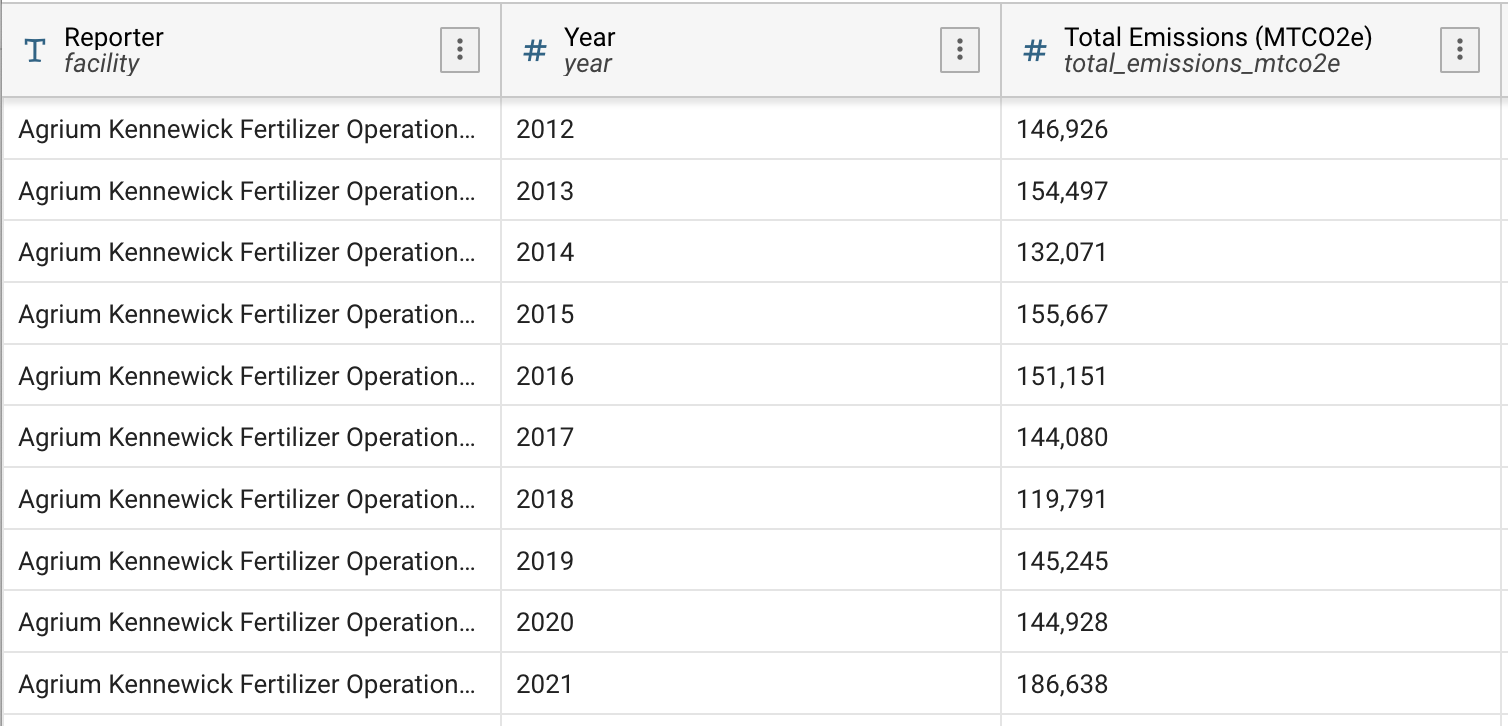

Just to investigate, I want to find the facilities with the top five emissions. To do this most efficiently, I googled methods to get the top five values from a dictionary and found that I can use three methods together to accomplish this: `itemgetter()`, `items()`, and `sorted()`.

In [10]:
from operator import itemgetter

#I will make N equal to 5 because I want to only get the greatest five values in the set. I can change this value if
#I want to get more or fewer of the facilities with top emissions. 
N = 5

result = dict(sorted(decade_facilities_total_emissions.items(), key=itemgetter(1), reverse=True)[:N])

pprint(result)

{'HollyFrontier Puget Sound Refinery LLC - Anacortes': 19235767,
 'Nippon Dynawave - Longview': 15779251,
 'TransAlta Centralia Generation LLC - Centralia': 59338269,
 'WestRock LLC - Longview': 16317134,
 'bp Cherry Point Refinery - Blaine': 20486310}


The next aspect I am interested in investigating is how the reported emissions trended over the years amongst these companies. I am going to calculate the total emissions by year and see if the emissions from these groups went up, down, or oscillated as the years have gone on. I think it would be informative to represent the totals from each year in a bar chart to visualize this data.  

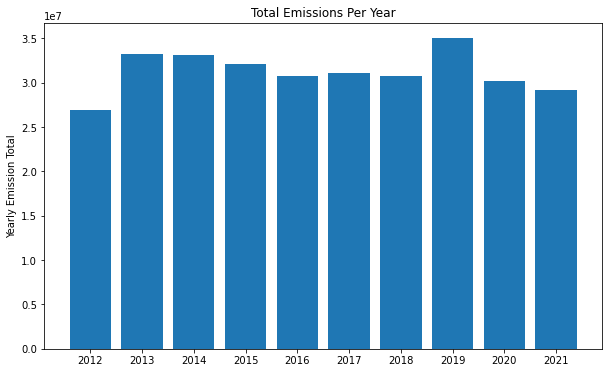

<Figure size 432x288 with 0 Axes>

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

yte = {}

for index, row in ghg_emissions.iterrows():
    year = row['Year']
    
    if year not in yte.keys():
        yte[year] = 0
    else:
        pass
    
for index, row in ghg_emissions.iterrows():
    facility = row['Reporter']
    year = row['Year']
    
    if facility in decade_facilities_total_emissions.keys():
        yte[year] += row['Total Emissions (MTCO2e)']
    else:
        pass


    
# Create figure and axes objects  
fig, ax = plt.subplots(figsize=(10, 6))


# Create bar plot
ax.bar(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'], 
       [yte[2012], yte[2013], yte[2014], yte[2015], yte[2016], yte[2017], yte[2018], yte[2019], yte[2020], yte[2021]])

# Customize plot
ax.set_title('Total Emissions Per Year')
ax.set_ylabel('Yearly Emission Total')

# Display plot
plt.show()
plt.savefig('total_emissions_per_year_ten_group.png', bbox_inches='tight')
    
#pprint(yearly_total_emissions)

#### Analyzing the bar chart
Upon first glance of this bar chart, it seems like a gradual decline from 2013 was occuring, except for a sharp spike in 2019 that interrupted the decline. Just for fun, I am going to do this same process of calculating the sum for each year with all of the facilities in the dataset, including those that didn't report every year over the ten years. 

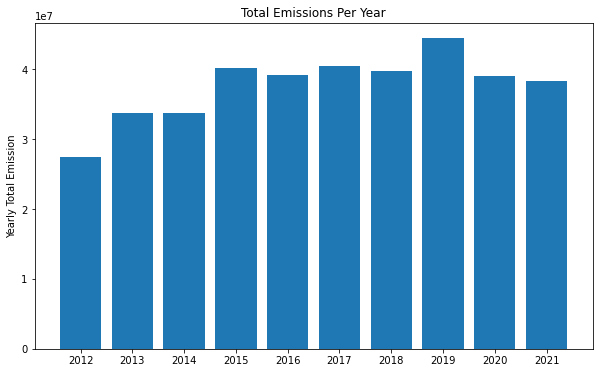

<Figure size 432x288 with 0 Axes>

In [29]:
ytea = {}

for index, row in ghg_emissions.iterrows():
    year = row['Year']
    
    if year not in ytea.keys():
        ytea[year] = 0
    else:
        pass
    
for index, row in ghg_emissions.iterrows():
    year = row['Year']
    ytea[year] += row['Total Emissions (MTCO2e)']

    
# Create figure and axes objects  
fig, ax = plt.subplots(figsize=(10, 6))


# Create bar plot
ax.bar(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'], 
       [ytea[2012], ytea[2013], ytea[2014], ytea[2015], ytea[2016], ytea[2017], ytea[2018], ytea[2019], ytea[2020], ytea[2021]])

# Customize plot
ax.set_title('Total Emissions Per Year')
ax.set_ylabel('Yearly Total Emission')

# Display plot
plt.show()
plt.savefig('total_emissions_per_year.png', bbox_inches='tight')


The calculations using all facilities in the dataset seems to tell a different story. There seems to be an upward trend from 2012 on with a hard spike still at 2019. It then seems to taper off in 2020 and 2021, and part of me wonders if the pandemic had any impact on that change in trend. That is purely speculation though, and I don't have any way to really test that hypothesis. 

#### Analyzing Big Fire Data
I am going to follow a similar process as I've done before and create a list of dictionaries from all of the data entries where every dictionary contains the name of the fire, year, and the acres that were impacted by the fire

In [13]:
#create a new empty dictionary
import pandas as pd
fire_data = pd.read_csv('Washington_Large_Fires_1973-2020.csv')

#Initiate and insert keys into dictionary that will store the total acres damaged by wildfires for each year. 
fire_yearly_total_acreage = {}
for index, row in fire_data.iterrows():
    year = row['YEAR']
    
    if year not in fire_yearly_total_acreage.keys():
        fire_yearly_total_acreage[year] = 0  
    else:
        pass
    
pprint(fire_yearly_total_acreage)

{1973: 0,
 1984: 0,
 1985: 0,
 1986: 0,
 1987: 0,
 1988: 0,
 1989: 0,
 1990: 0,
 1991: 0,
 1992: 0,
 1993: 0,
 1994: 0,
 1995: 0,
 1996: 0,
 1997: 0,
 1998: 0,
 1999: 0,
 2000: 0,
 2001: 0,
 2002: 0,
 2003: 0,
 2004: 0,
 2005: 0,
 2006: 0,
 2007: 0,
 2008: 0,
 2009: 0,
 2010: 0,
 2011: 0,
 2012: 0,
 2013: 0,
 2014: 0,
 2015: 0,
 2016: 0,
 2017: 0,
 2018: 0,
 2019: 0,
 2020: 0,
 2021: 0,
 2022: 0}


Just from this initial generation of a dicitonary with all of the years where data was recorded about fire, I can see a weird discrepancy wherein data collection seemed to randomly skip from 1973-1984. While I think this is odd, I am grateful that it is irrelevant to my data anlysis. Since we only have greenhouse gas emissions from 2012 on, I really will only be looking at acreage damage from 2012 to 2021. Another interesting this is that the title of this dataset said it contained data about fires from 1973-2020, but from this dictionary generation, I can see that there is supposedly data into 2022. This is great because it slightly widens the timespan of the analysis. Now I will generate the total acres damaged each year using this dictionary I just created. 

In [14]:
for index, row in fire_data.iterrows():
    year = row['YEAR']
    acre_damage = row['ACRES']
    fire_yearly_total_acreage[year] += acre_damage

pprint(fire_yearly_total_acreage)

{1973: 499.72147776,
 1984: 127920.46980238,
 1985: 80770.63384605,
 1986: 24323.6732772,
 1987: 24320.377253799998,
 1988: 24462.88078175,
 1989: 10147.44704571,
 1990: 31537.984687980002,
 1991: 32105.036891080003,
 1992: 45730.397995010004,
 1993: 11412.20973974,
 1994: 95569.40368953999,
 1995: 1287.09939744,
 1996: 3019.12954666,
 1997: 1923.31062023,
 1998: 18500.4198579,
 1999: 11229.679277430001,
 2000: 9606.77621975,
 2001: 163826.80979618,
 2002: 34977.40217864,
 2003: 133707.5321086,
 2004: 85164.55329910002,
 2005: 83678.46022738998,
 2006: 379760.46093538,
 2007: 270069.63077144994,
 2008: 84604.94757773998,
 2009: 74096.01231104003,
 2010: 78662.72941598999,
 2011: 26986.343757720002,
 2012: 412541.91389423003,
 2013: 148772.38434715001,
 2014: 434597.6592827601,
 2015: 1137393.93325744,
 2016: 305153.49869520013,
 2017: 402698.50665077,
 2018: 407426.39776957,
 2019: 133162.32192962,
 2020: 802630.7378675499,
 2021: 684795.3369308698,
 2022: 165479.63318891}


Now, just for visual interest, I am going to display this data in bar chart form for the same years as I displayed yearly total emissions.  

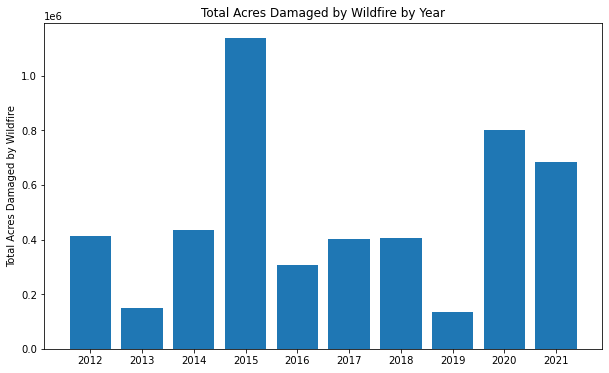

<Figure size 432x288 with 0 Axes>

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fyta = fire_yearly_total_acreage

# Create figure and axes objects  
fig, ax = plt.subplots(figsize=(10, 6))


# Create bar plot
ax.bar(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'], 
       [fyta[2012], fyta[2013], fyta[2014], fyta[2015], fyta[2016], fyta[2017], fyta[2018], fyta[2019], fyta[2020], fyta[2021]])

# Customize plot
ax.set_title('Total Acres Damaged by Wildfire by Year')
ax.set_ylabel('Total Acres Damaged by Wildfire')

# Display plot
plt.show()
plt.savefig('total_acres_damaged_by_wildfire_by_year.png', bbox_inches='tight')

    
#pprint(yearly_total_emissions)

Now, I am considering a alternative way of analyzing this fire data. Instead of recording the total acreage of damage by wildfires each year, I am going to record how many separate wildfires happened each year. I will follow all the same steps of creating the dictionary with a key for each year, but instead of aggregating the number of acres from each data entry, I will just increment the count of each value by one every time I encounter a data entry with a fire from a given year. 

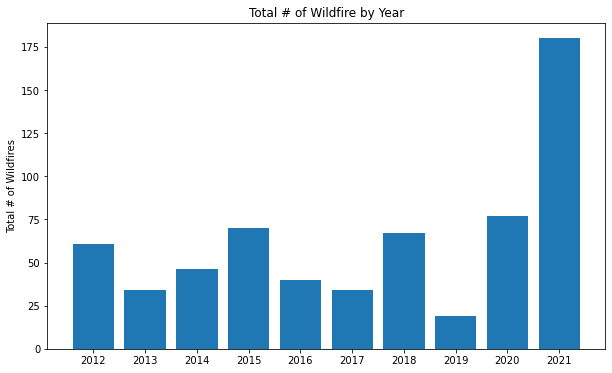

In [16]:
#create a new empty dictionary
import pandas as pd
fire_data = pd.read_csv('Washington_Large_Fires_1973-2020.csv')

#Initiate and insert keys into dictionary that will store the total number of fires for each year
fire_yearly_total_count = {}
for index, row in fire_data.iterrows():
    year = row['YEAR']
    
    if year not in fire_yearly_total_count.keys():
        fire_yearly_total_count[year] = 0  
    else:
        pass
    
#pprint(fire_yearly_total_count)

#Iterate through dataset and update the corresponding year key for every reported data entry
for index, row in fire_data.iterrows():
    year = row['YEAR']
    fire_yearly_total_count[year] += 1

#pprint(fire_yearly_total_count)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fytc = fire_yearly_total_count

# Create figure and axes objects  
fig, ax = plt.subplots(figsize=(10, 6))


# Create bar plot
ax.bar(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'], 
       [fytc[2012], fytc[2013], fytc[2014], fytc[2015], fytc[2016], fytc[2017], fytc[2018], fytc[2019], fytc[2020], fytc[2021]])

# Customize plot
ax.set_title('Total # of Wildfire by Year')
ax.set_ylabel('Total # of Wildfires')

# Display plot
plt.show()
plt.savefig('total_number_of_wildfires_by_year.png', bbox_inches='tight')


### Synthesizing Big Fire Data and GHG Emissions
Now, I want to compare these datasets to see if there is any correlation between greenhouse gas emissions and fire damage. I will create x and y values to plot by taking the total greenhouse gas emissions as well as the number of acres destroyed from one year. For the total greenhouse gas emission totals, I will be using the dictionary the contains the yearly total emission amount instead of the total emission amount from the set of facilities that reported every year across the 10 years. 

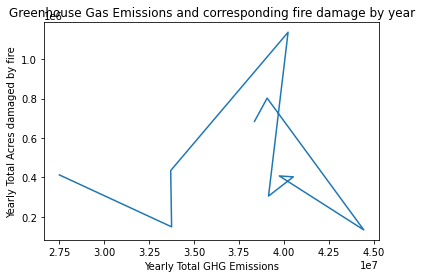

In [23]:
import matplotlib.pyplot as plt

x_axis = [ytea[2012], ytea[2013], ytea[2014], ytea[2015], ytea[2016], ytea[2017], ytea[2018], ytea[2019], ytea[2020], ytea[2021]]

y_axis = [fyta[2012], fyta[2013], fyta[2014], fyta[2015], fyta[2016], fyta[2017], fyta[2018], fyta[2019], fyta[2020], fyta[2021]]

#plot the data with appropriate corresponding labels
plt.plot(x_axis, y_axis)
plt.title('Greenhouse Gas Emissions and corresponding fire damage by year')
plt.xlabel('Yearly Total GHG Emissions')
plt.ylabel('Yearly Total Acres damaged by fire')
plt.show()
    

Well, this is almost comical! Obviously a realistic linear slope cannot be deduced from a line plot that looks like this! Now, just for analytical purposes, maybe I will just have plot points and then find a best fit line. I feel like that would yield a more realistic analysis. I attempted to add an element that would display the equation for the best linear fit for visibility purposes. 

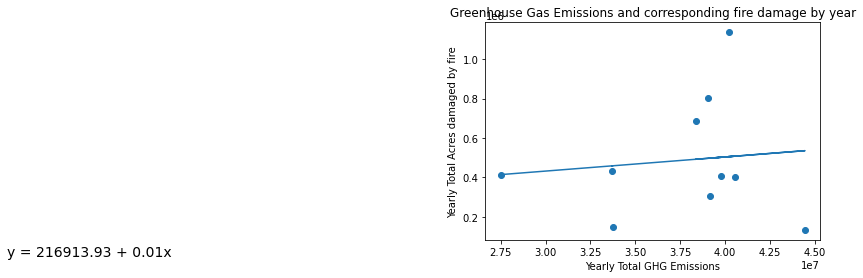

In [31]:
import numpy as np
import matplotlib.pyplot as plt

#define data
x = np.array([ytea[2012], ytea[2013], ytea[2014], ytea[2015], ytea[2016], ytea[2017], ytea[2018], ytea[2019], ytea[2020], ytea[2021]])
y = np.array([fyta[2012], fyta[2013], fyta[2014], fyta[2015], fyta[2016], fyta[2017], fyta[2018], fyta[2019], fyta[2020], fyta[2021]])

#find line of best fit
a, b = np.polyfit(x, y, 1)

#add points to plot
plt.scatter(x, y)

#add line of best fit to plot
plt.plot(x, a*x+b) 
plt.title('Greenhouse Gas Emissions and corresponding fire damage by year')
plt.xlabel('Yearly Total GHG Emissions')
plt.ylabel('Yearly Total Acres damaged by fire')

plt.text(1, 17, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=14)

plt.savefig('ghg_emissions_and_fire_damage.png', bbox_inches='tight')



This is a much cleaner attempt to generate a best fit line that would potentially lead to some substantiative evidence that there was a relationship between the yearly total emissions and the yearly total acres damaged by fire. While there is a slight positive slope on the best fit line, the data points seem so scattered and erratic, and a chronological element pertaining to these results is completely excluded, which seems to discount the idea that climate change and greenhouse gas emissions are a compounding issue rather than a condition that resets every calendar year.

## Findings
I would say that I was able deduce more interesting findings from the individual datasets rather than the synthesis of the two. My main two findings where that greenhouse gas emissions are increasing in Washington State due to the occurance of more and more facilities that produce GHG rather than facilities producing more GHG over time. Another substantial finding was that more individual occurance of wildfires in Washington State did not mean that more damage was done.

## Discussion
### Limitations
I think one major limitation to this study was that I didn't have a way to gauge the completeness of these datasets. I couldn't know how much of the actual quantity of emissions or total acres damaged or total fire occurances was actually being accurately reported. This analysis was more indicative than it was complete by any standard. Another limitation was that I don't have a ton of familiarity with statistics, and therefore wasn't super confident with running a linear regression test, and ultimately was unimpressed by the generation of a best fit line when comparing total greenhouse gas emissions to its corresponding amount of wildfire damage for that year. Therefore, I didn't reach a conclusion about the impact of greenhouse gas emissions on wildfire damage from the data I worked with.

### Implications
The implications of this study are mostly to offer more information about the nature of greenhouse gas emission production in the state of washington as well as inform about wildfire seasons. 

## Conclusion
The conclusions that I ultimately came to through this study was that increase in GHG emissions is mostly due to the creation of new facilities that produce these emissions, as well as the fact that the amount of damage done by wildifres is not dependent on how many wildfires occured each year.